In [ ]:
library(dplyr)
library(DESeq2)
library(sva)
library(RColorBrewer)
library(pheatmap)
library(stringr)
library(EnhancedVolcano)
library(clusterProfiler)
library(org.Hs.eg.db)
library(AnnotationDbi)

In [2]:
counts_matrix = readRDS('../data/bulk/bulk_raw_counts.rds')
colnames(counts_matrix)

[1] "human_adipose_3"  "human_brain_4"    "human_heart_2"    "human_kidney_2"  
 [5] "human_liver_2"    "human_lung_3"     "human_pancreas_4" "human_spleen_2"  
 [9] "mouse_adipose_1"  "mouse_brain_4"    "mouse_heart_5"    "mouse_kidney_5"  
[13] "mouse_liver_5"    "mouse_lung_1"     "mouse_pancreas_1" "mouse_spleen_4"

In [3]:
counts_metadata = data.frame(colnames(counts_matrix), NA, NA,stringsAsFactors = FALSE)
colnames(counts_metadata) = c("sample", "species", "tissue")
counts_metadata$species = 'mouse'
counts_metadata$species[grepl("human",colnames(counts_matrix))] = 'human'
counts_metadata$tissue = str_split(colnames(counts_matrix), '_', simplify = T)[,2]
counts_metadata$sample = as.factor(str_split(colnames(counts_matrix), '_', simplify = T)[,3])
rownames(counts_metadata) = colnames(counts_matrix)
counts_metadata

,sample,species,tissue
,<fct>,<chr>,<chr>
human_adipose_3,3,human,adipose
human_brain_4,4,human,brain
human_heart_2,2,human,heart
human_kidney_2,2,human,kidney
human_liver_2,2,human,liver
human_lung_3,3,human,lung
human_pancreas_4,4,human,pancreas
human_spleen_2,2,human,spleen
mouse_adipose_1,1,mouse,adipose


In [4]:
dds = DESeqDataSetFromMatrix(countData = counts_matrix,
                              colData = counts_metadata,
                              design = ~ tissue + species ) %>% estimateSizeFactors() %>% estimateDispersions()

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



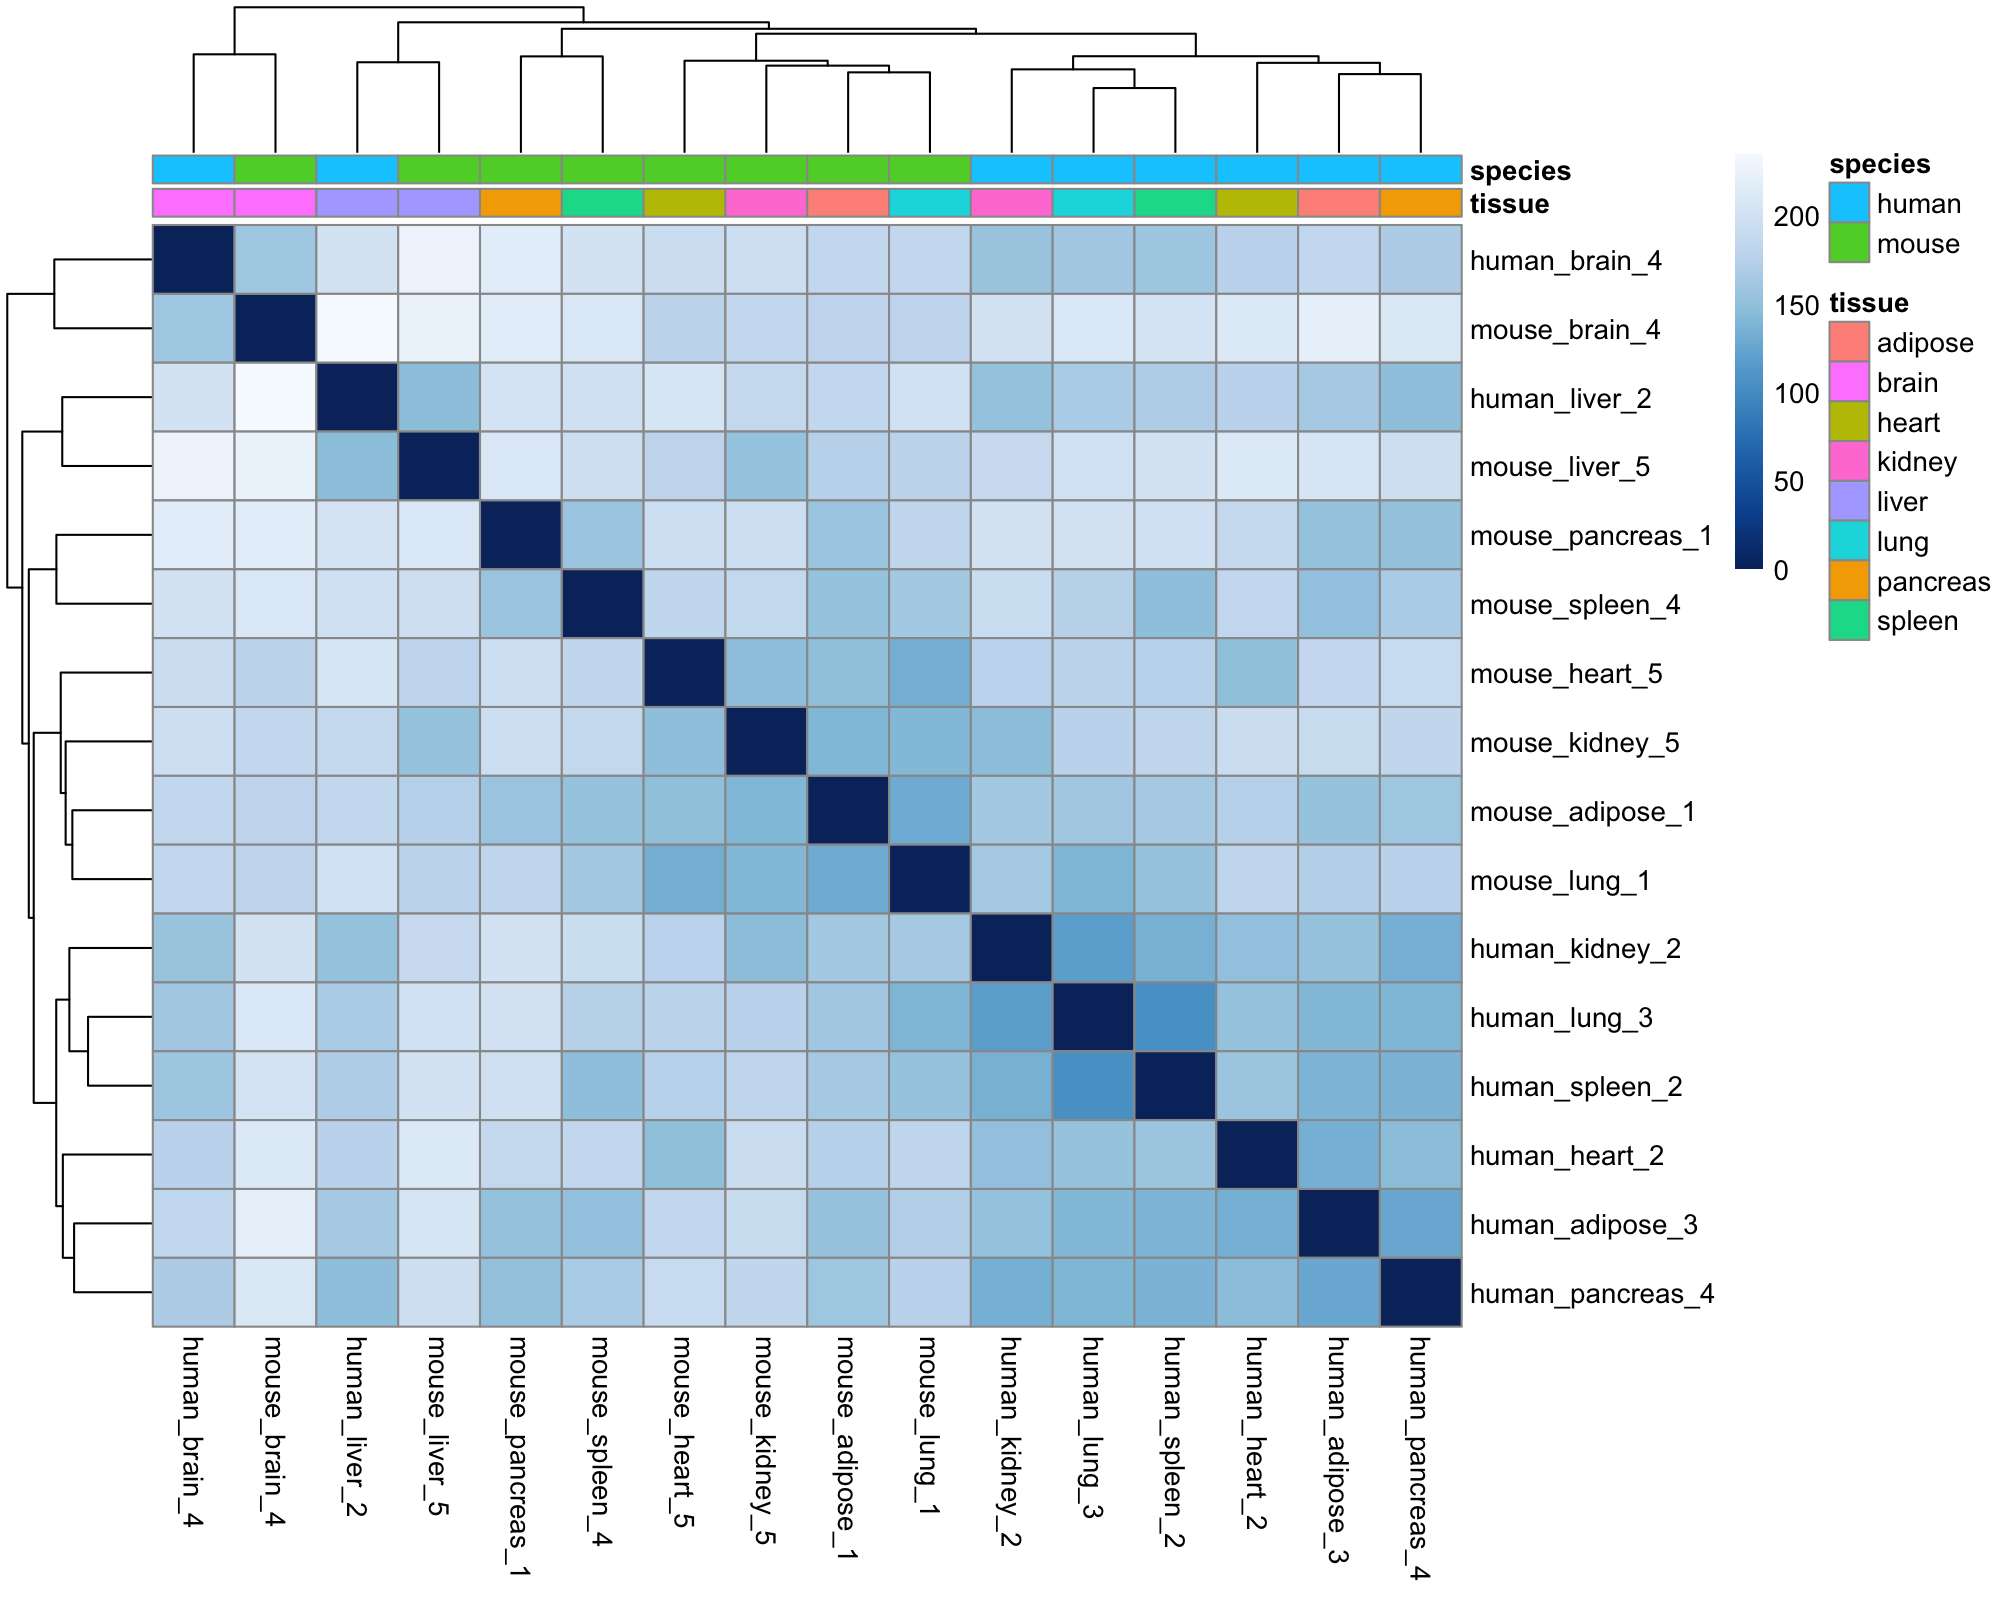

In [5]:
vsd = vst(dds, blind=F)

sampleDists = dist(t(assay(vsd)))
sampleDistMatrix = as.matrix(sampleDists)
rownames(sampleDistMatrix) = rownames(counts_metadata)
colnames(sampleDistMatrix) = rownames(counts_metadata)
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         show_rownames=T, annotation_col=counts_metadata[,c('tissue','species')], col=colors)


using ntop=500 top features by variance



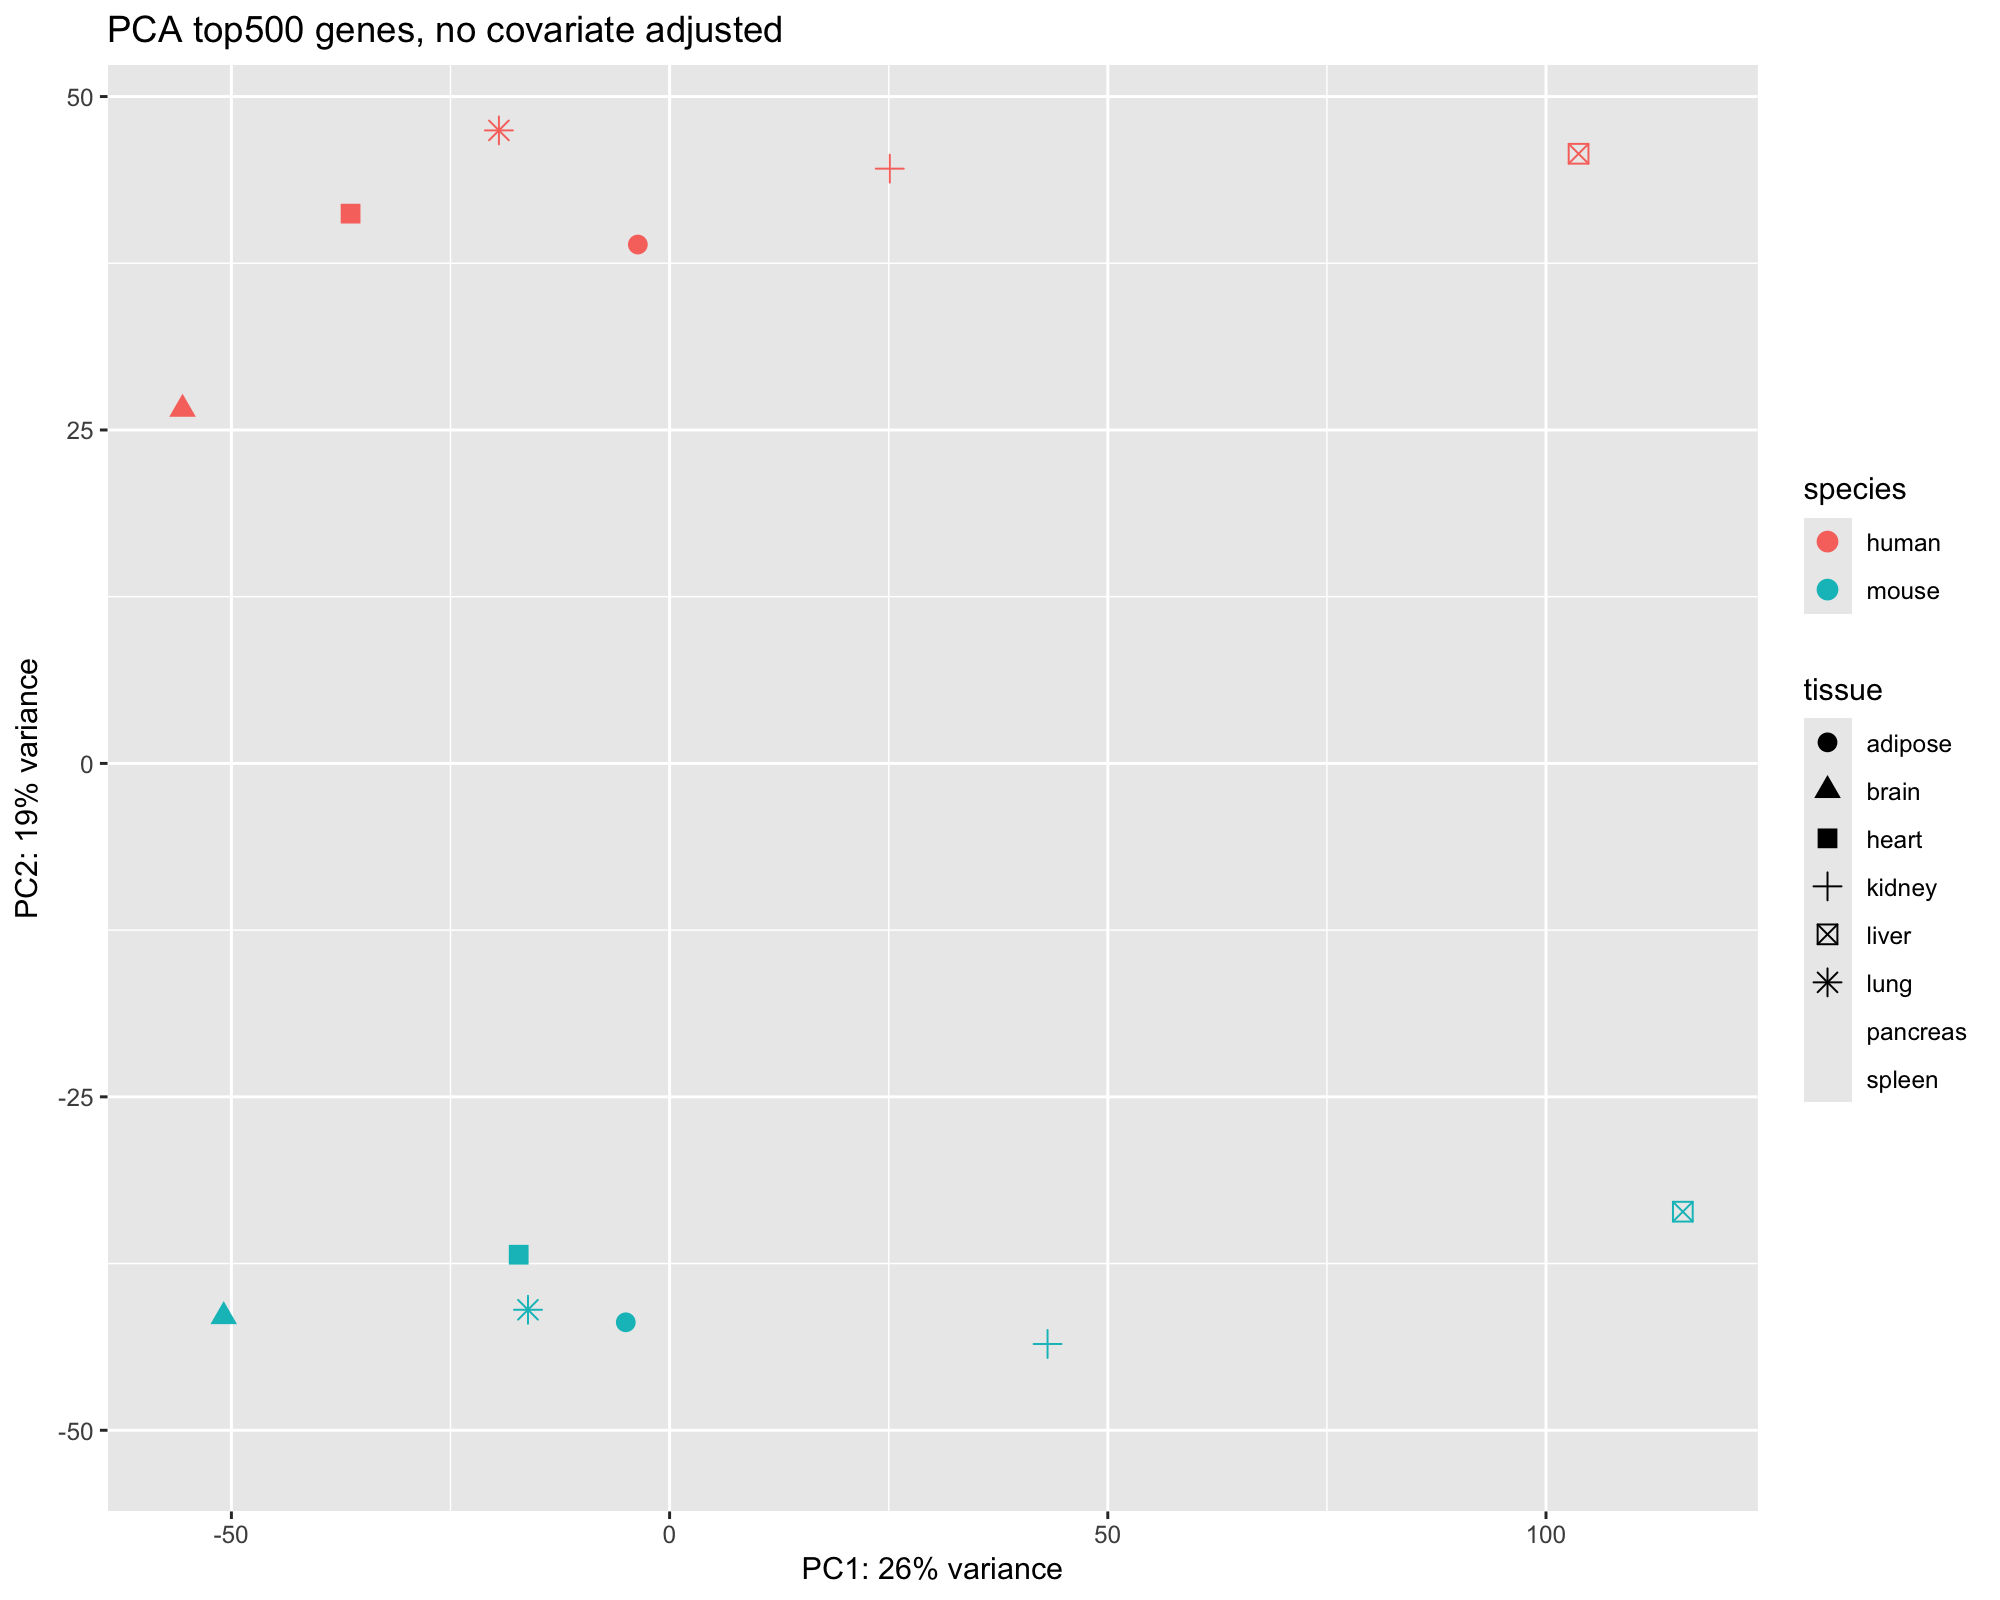

In [6]:
se = SummarizedExperiment(log2(counts(dds, normalized=TRUE) + 1),
                           colData=colData(dds))
pcaData = plotPCA(DESeqTransform(se), intgroup=c('species','tissue'),returnData = TRUE)
percentVar = round(100 * attr(pcaData, "percentVar")) 

ggplot(pcaData, aes(x = PC1, y = PC2, color=species, shape=tissue)) + 
geom_point(size=3) + 
xlab(paste0("PC1: ", percentVar[1], "% variance")) + 
ylab(paste0("PC2: ", percentVar[2], "% variance")) + 
ggtitle("PCA top500 genes, no covariate adjusted")


Found 825 genes with uniform expression within a single batch (all zeros); these will not be adjusted for batch.


Found2batches

Adjusting for0covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


using ntop=500 top features by variance



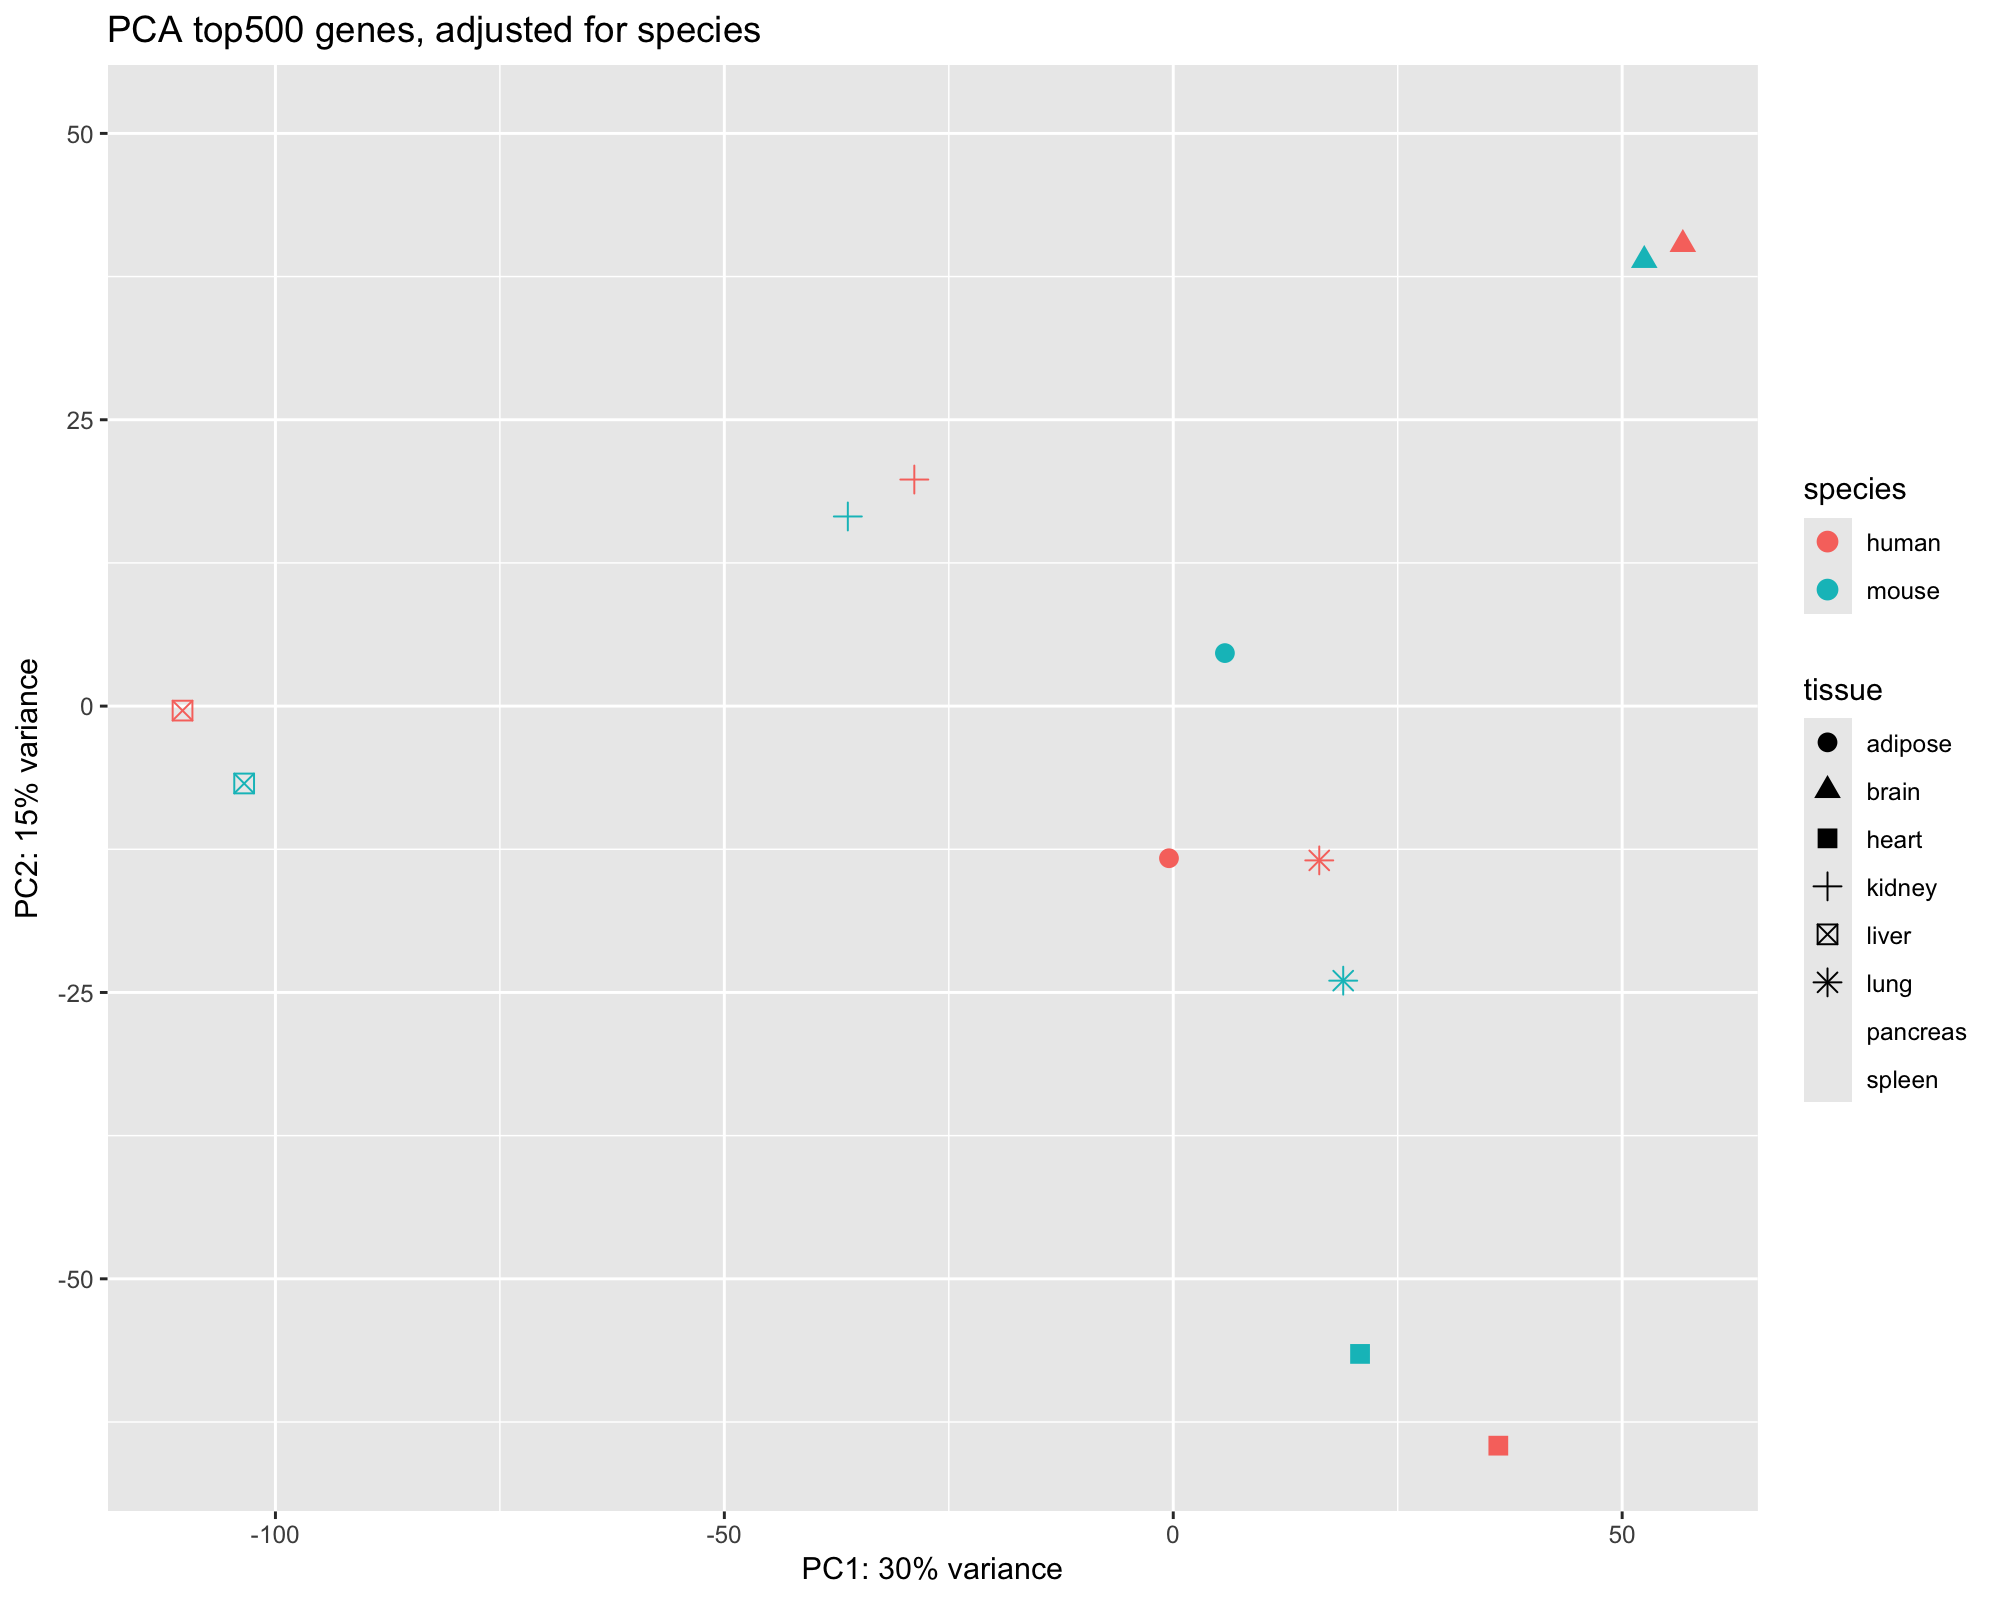

In [7]:
combat_dat = ComBat(log2(counts(dds, normalized=TRUE) + 1), dds$species, par.prior = TRUE)
se = SummarizedExperiment(combat_dat,colData=colData(dds))
pcaData = plotPCA( DESeqTransform( se ) ,intgroup=c('species', 'tissue'),returnData = TRUE)
percentVar = round(100 * attr(pcaData, "percentVar")) 

ggplot(pcaData, aes(x = PC1, y = PC2, color=species, shape=tissue)) + 
geom_point(size=3) + 
xlab(paste0("PC1: ", percentVar[1], "% variance")) + 
ylab(paste0("PC2: ", percentVar[2], "% variance")) + 
ggtitle("PCA top500 genes, adjusted for species")


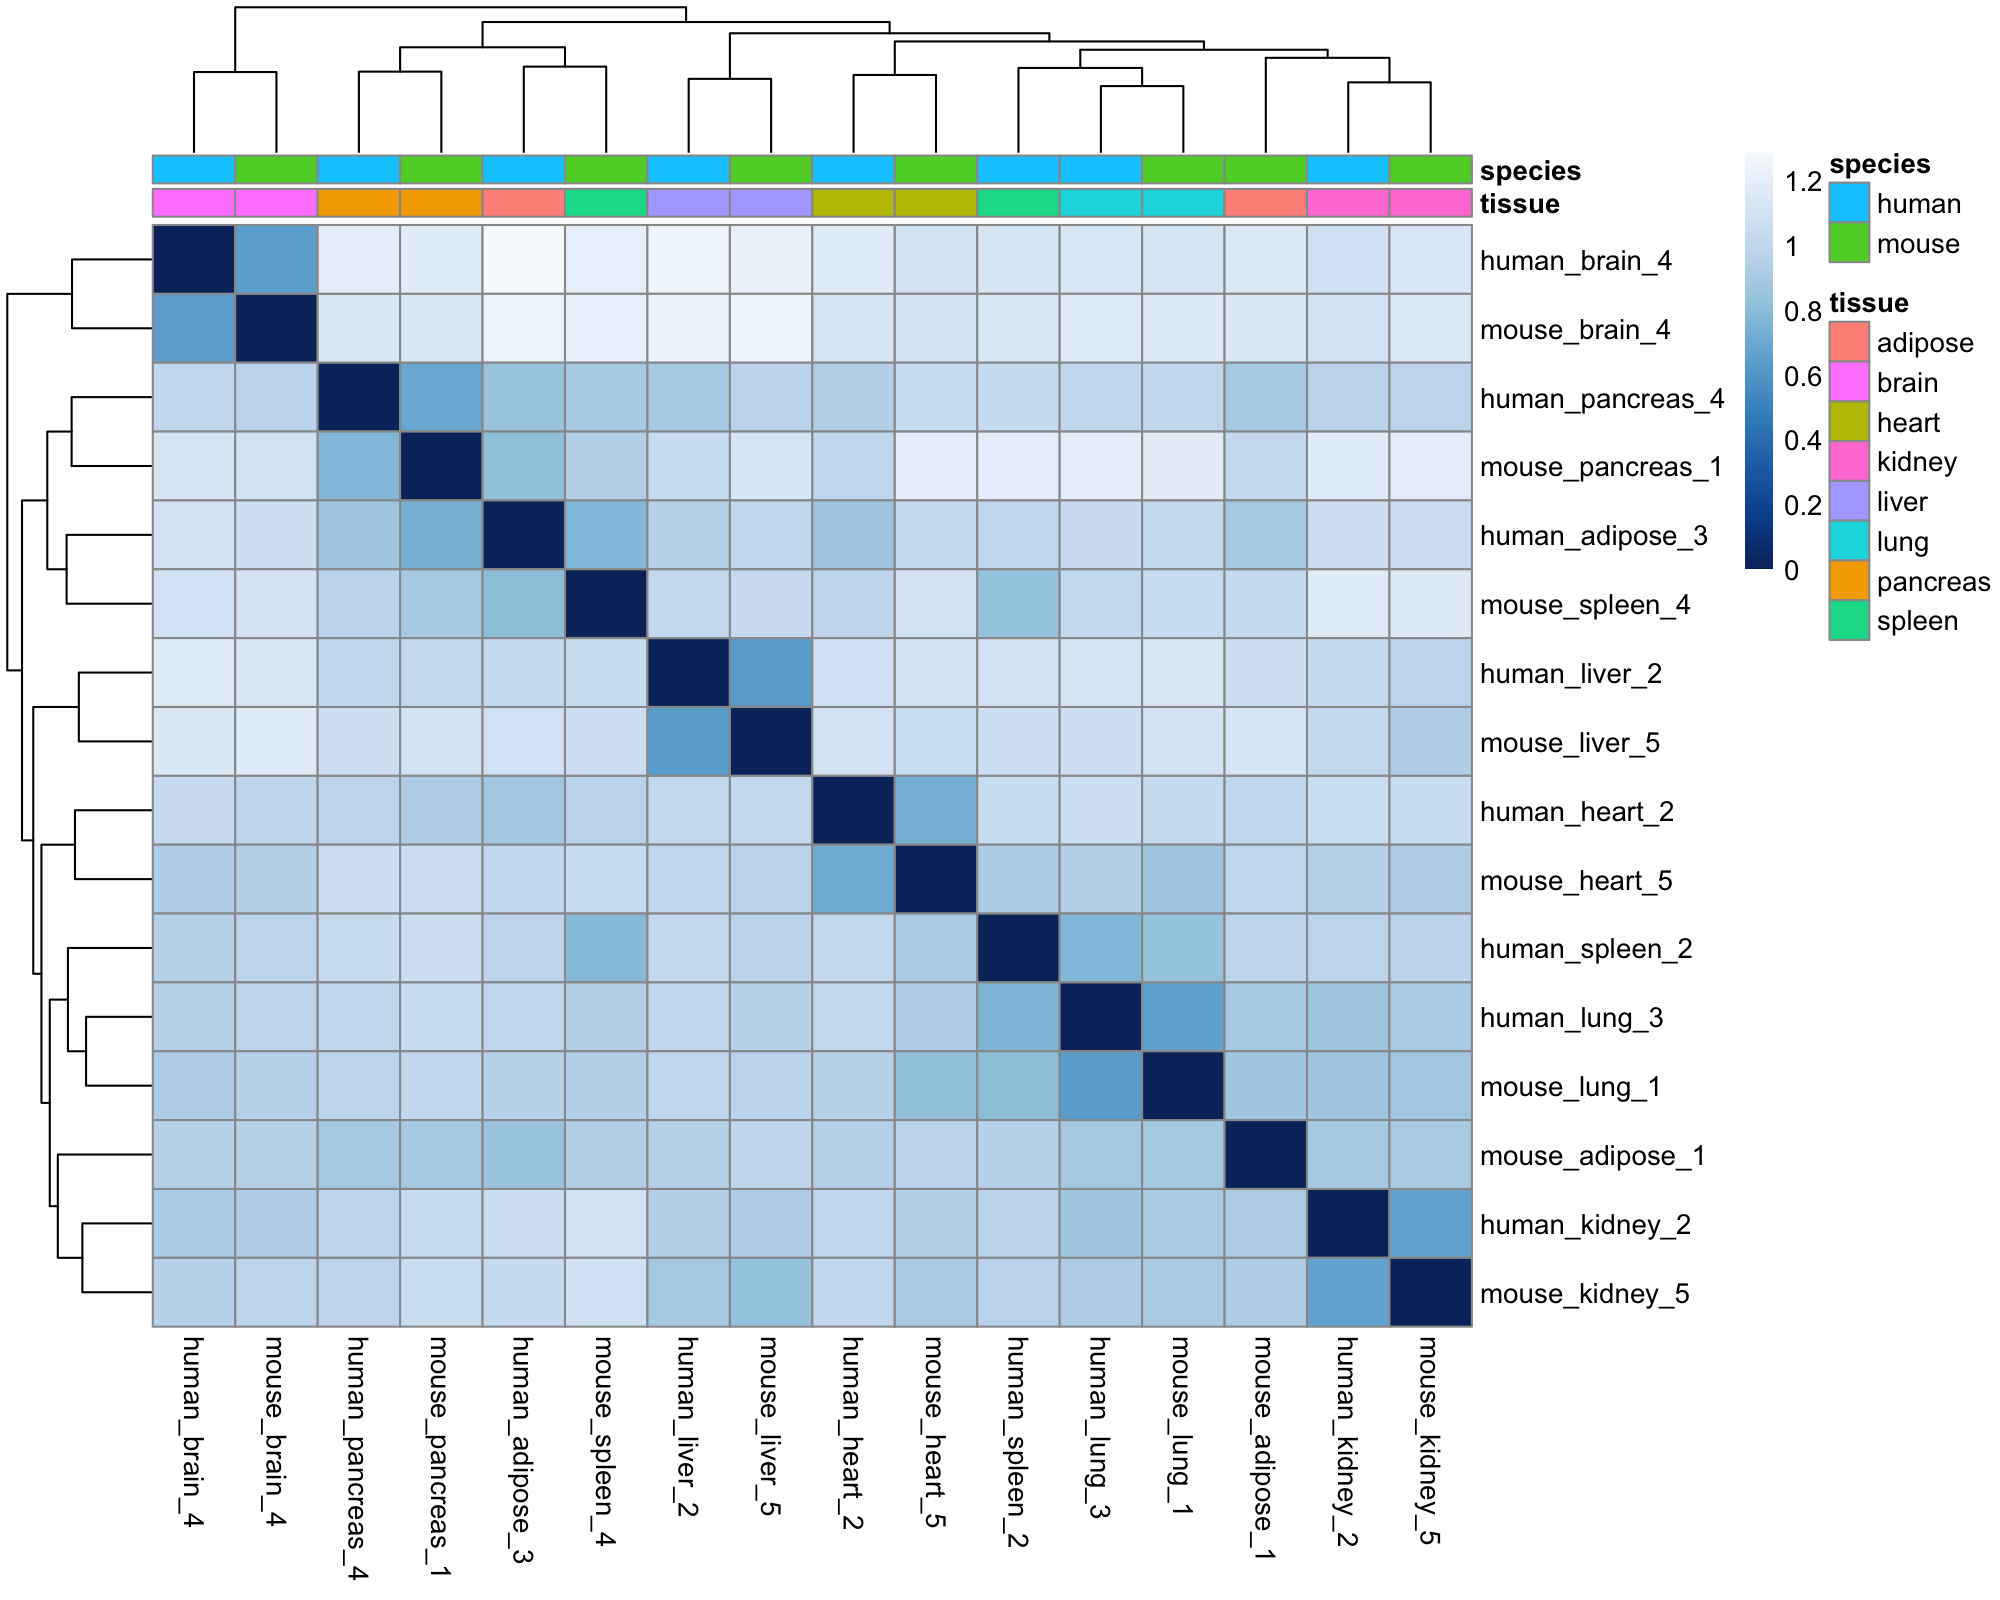

In [8]:
sampleDists = dist(t(combat_dat))
sampleDistMatrix = scale(as.matrix(sampleDists), center = F)
rownames(sampleDistMatrix) = rownames(counts_metadata)
colnames(sampleDistMatrix) = rownames(counts_metadata)
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)

colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows=sampleDists,
         clustering_distance_cols=sampleDists,
         show_rownames=T, annotation_col=counts_metadata[,c('tissue','species')], col=colors)


In [9]:
library(sva)

idx = rowMeans(counts(dds)) > 16
dat = counts(dds)[idx,]
mod = model.matrix(~ species + tissue, colData(dds))
mod0 = model.matrix(~ 1, colData(dds))
svseq = svaseq(dat, mod, mod0)

Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [10]:
dds@colData$species = as.factor(dds@colData$species)
dds@colData$tissue = as.factor(dds@colData$tissue)
ddssva = dds[idx,]
ddssva$SV1 = svseq$sv[,1]
ddssva$SV2 = svseq$sv[,2]
design(ddssva) = ~ SV1 + SV2 + species + tissue
ddssva = DESeq(ddssva)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [11]:
resultsNames(ddssva)

[1] "Intercept"                  "SV1"                       
 [3] "SV2"                        "species_mouse_vs_human"    
 [5] "tissue_brain_vs_adipose"    "tissue_heart_vs_adipose"   
 [7] "tissue_kidney_vs_adipose"   "tissue_liver_vs_adipose"   
 [9] "tissue_lung_vs_adipose"     "tissue_pancreas_vs_adipose"
[11] "tissue_spleen_vs_adipose"

In [12]:
res = lfcShrink(ddssva, coef="tissue_brain_vs_adipose", type="apeglm")

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895



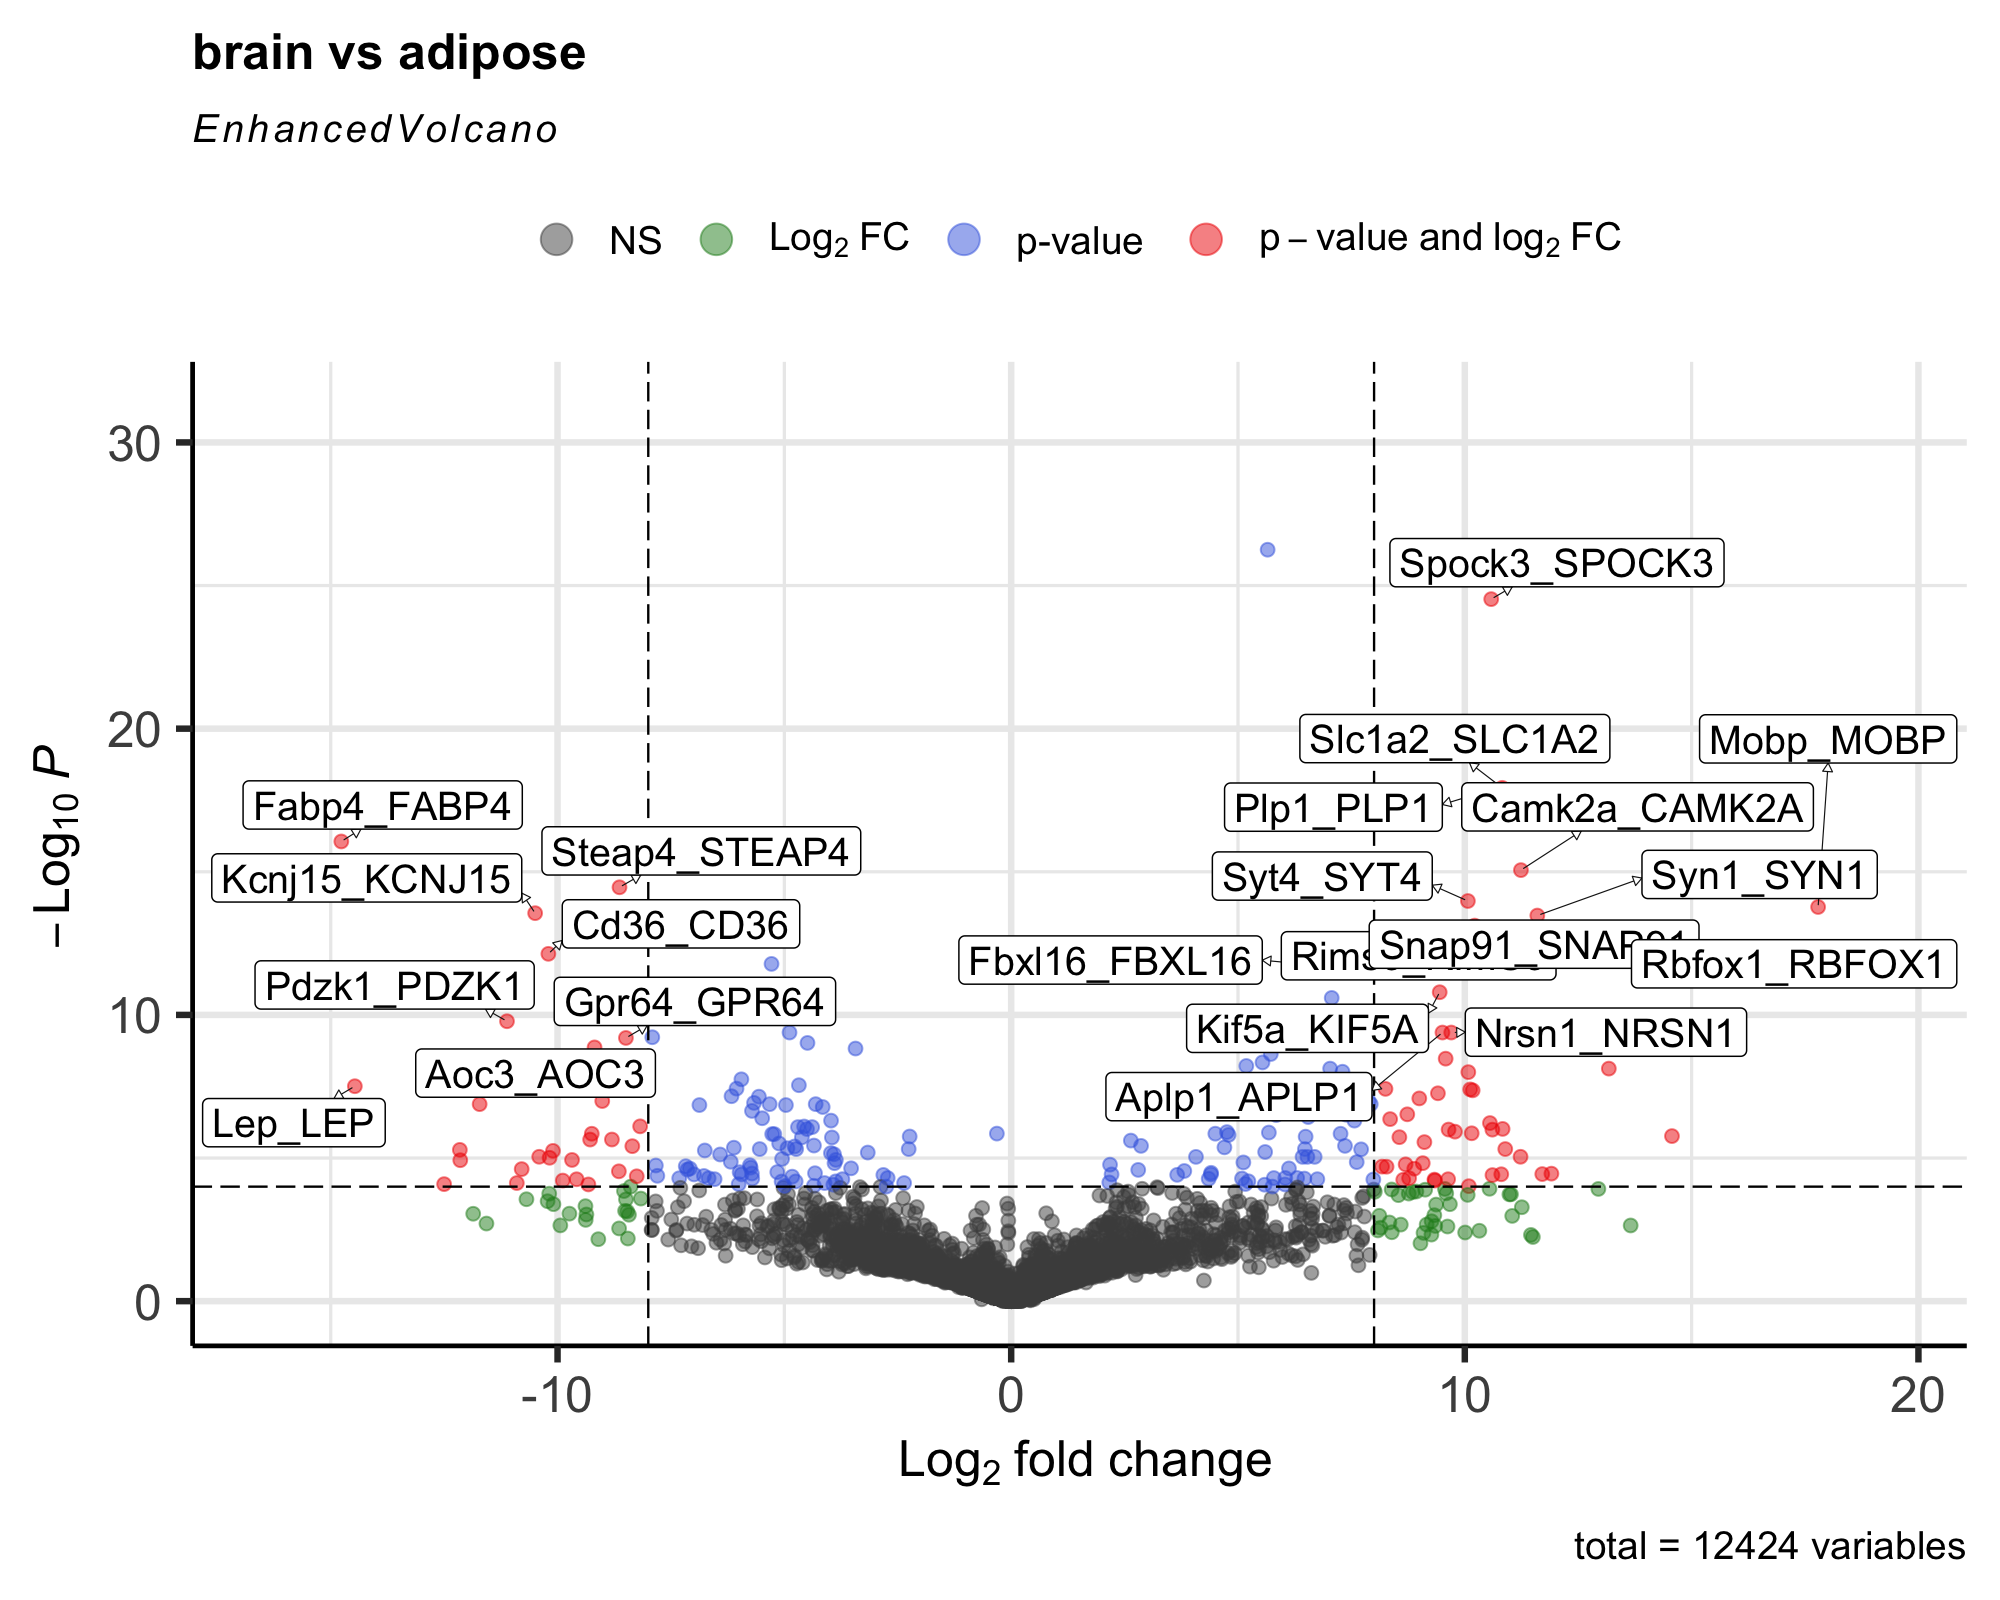

In [13]:
EnhancedVolcano(res,
lab = rownames(res),
x = 'log2FoldChange', boxedLabels = T,
                drawConnectors = TRUE,
    widthConnectors = 0.2,title= 'brain vs adipose',
y = 'padj',FCcutoff = 8, pCutoff = 10e-5)


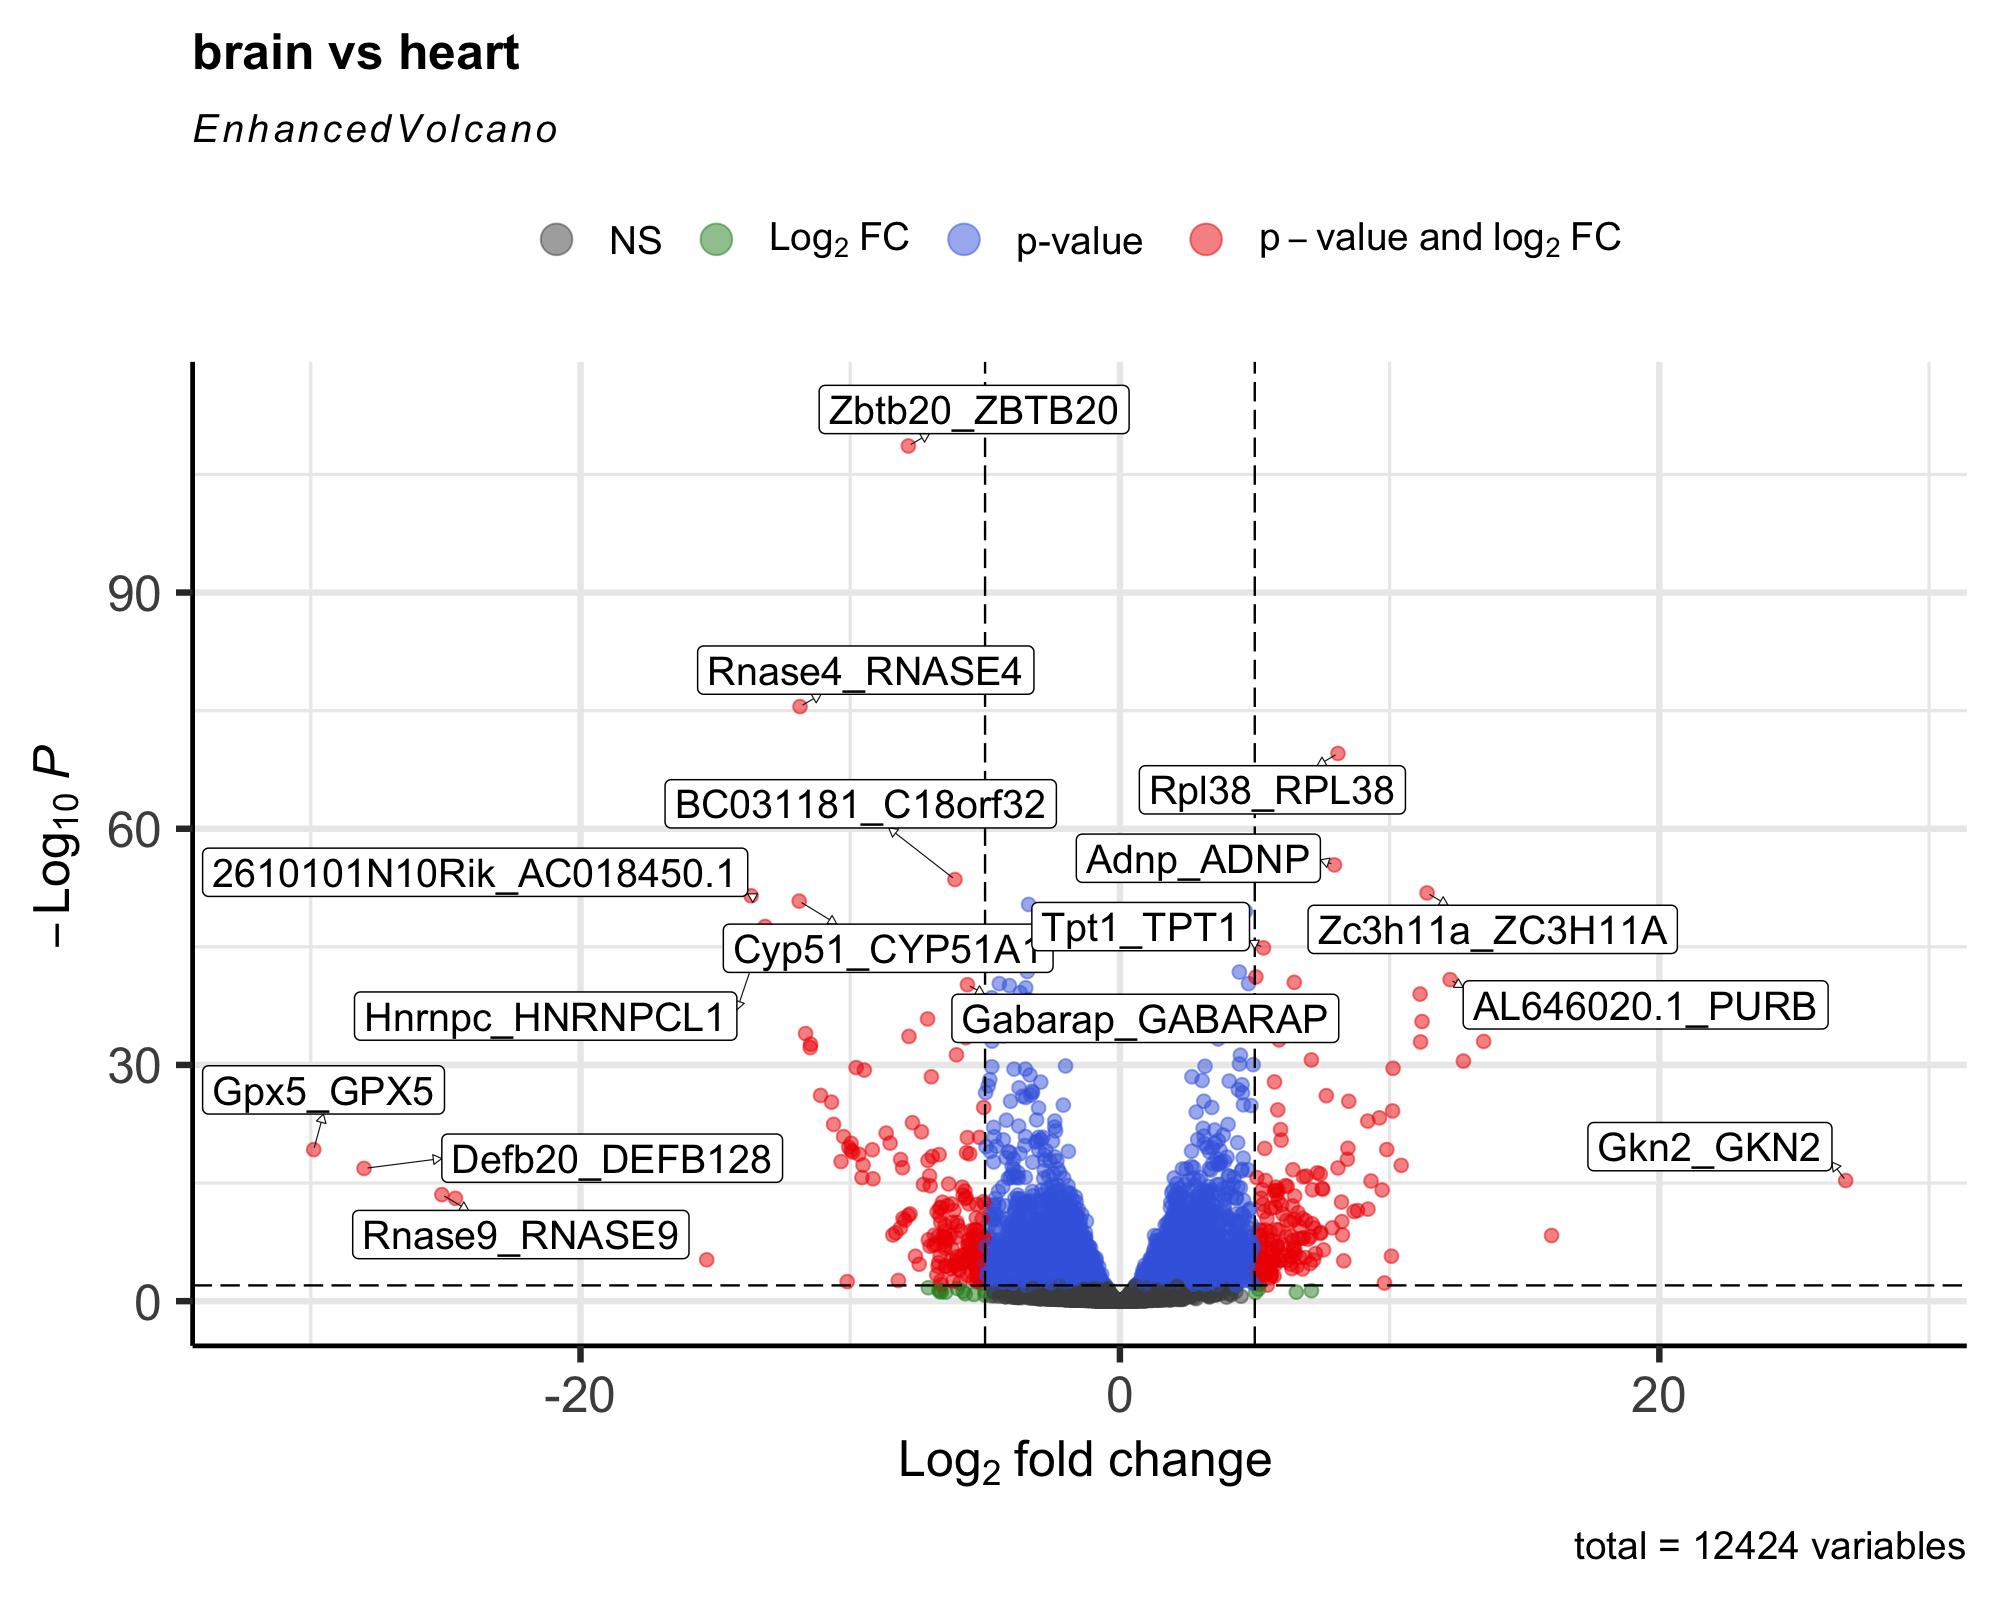

In [14]:
bh = results(ddssva, contrast=c('species',"human", "mouse"))
EnhancedVolcano(bh,
lab = rownames(bh),
x = 'log2FoldChange', boxedLabels = T,
                drawConnectors = TRUE,
    widthConnectors = 0.2,title= 'brain vs heart',
y = 'padj',FCcutoff = 5, pCutoff = 10e-3)


In [21]:
head(rownames(subset(bh, log2FoldChange>=5 & padj<= 10e-3)))

[1] "Spag16_SPAG16" "Dnase1_DNASE1" "Myot_TTN"      "Oas3_OAS3"    
[5] "Trim66_TRIM66" "Ovch2_OVCH2"

In [18]:
sigs = na.omit(res)
sigs = sigs[sigs$padj < 0.05 & sigs$baseMean > 50,]

genes_to_test = rownames(sigs[sigs$log2FoldChange > 0.5,])
genes_to_test = str_split(genes_to_test, '_', simplify = T)[,2]

In [19]:
GO_results = enrichGO(gene = genes_to_test, OrgDb = "org.Hs.eg.db", keyType = "SYMBOL", ont = "BP")
head(as.data.frame(GO_results))

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0050804,GO:0050804,modulation of chemical synaptic transmission,96/626,489/18870,5.177997e-47,1.326309e-43,1.123477e-43,PAFAH1B1/MAPT/ADCY1/UNC13C/UNC13A/TUBB2B/SIPA1L1/KIF5B/APBA2/MAP1A/CACNA1A/PRKAR1B/CDH2/RIMS3/RIMS1/MEF2C/PTPRD/SYT1/GSK3B/PTN/SCGN/CALB1/SYP/GPR158/HOMER1/LRRTM2/PRKCE/PRKCB/CACNB4/SYBU/SV2B/LGI1/RELN/SHANK1/KIT/CA2/GFAP/NEFH/ZDHHC2/SYNGR1/CHRM2/SNAP25/PPP3R1/GRIN3A/CAMK2A/CPLX1/CPLX2/CSPG5/GABBR1/CBLN2/CBLN1/NLGN3/NLGN1/STXBP1/SLC38A1/SLC6A1/SYT4/SYT11/SNCA/DBN1/GRM3/GRM1/KCNJ10/PPP3CA/PPP3CB/PFN2/TMEM108/PLCL2/MAPK8IP2/FAM107A/PREPL/NRXN1/LRRC4C/SHISA9/NRG3/RAB3A/YWHAH/YWHAG/SLC4A10/SLC4A8/CNTN4/CNTN2/SYN1/CLSTN2/RTN4/PPFIA2/RGS4/FYN/GRIA4/GRIA3/GRIA2/GRIA1/JPH4/ERC2/CELF4/AKAP5,96
GO:0099177,GO:0099177,regulation of trans-synaptic signaling,96/626,490/18870,6.256174e-47,1.326309e-43,1.123477e-43,PAFAH1B1/MAPT/ADCY1/UNC13C/UNC13A/TUBB2B/SIPA1L1/KIF5B/APBA2/MAP1A/CACNA1A/PRKAR1B/CDH2/RIMS3/RIMS1/MEF2C/PTPRD/SYT1/GSK3B/PTN/SCGN/CALB1/SYP/GPR158/HOMER1/LRRTM2/PRKCE/PRKCB/CACNB4/SYBU/SV2B/LGI1/RELN/SHANK1/KIT/CA2/GFAP/NEFH/ZDHHC2/SYNGR1/CHRM2/SNAP25/PPP3R1/GRIN3A/CAMK2A/CPLX1/CPLX2/CSPG5/GABBR1/CBLN2/CBLN1/NLGN3/NLGN1/STXBP1/SLC38A1/SLC6A1/SYT4/SYT11/SNCA/DBN1/GRM3/GRM1/KCNJ10/PPP3CA/PPP3CB/PFN2/TMEM108/PLCL2/MAPK8IP2/FAM107A/PREPL/NRXN1/LRRC4C/SHISA9/NRG3/RAB3A/YWHAH/YWHAG/SLC4A10/SLC4A8/CNTN4/CNTN2/SYN1/CLSTN2/RTN4/PPFIA2/RGS4/FYN/GRIA4/GRIA3/GRIA2/GRIA1/JPH4/ERC2/CELF4/AKAP5,96
GO:0050808,GO:0050808,synapse organization,88/626,483/18870,2.516422e-40,3.556543e-37,3.012643e-37,PAFAH1B1/MAPT/KIF1A/UNC13C/UNC13A/TUBB/SIPA1L1/RPS6KA5/ABI2/CDH2/ZNF365/MEF2C/PTPRD/L1CAM/NRCAM/GPR158/HOMER1/LRRTM2/LRRN1/LRRN3/LRFN5/ROBO2/CDH6/CACNB4/ARHGEF9/C1QL3/SYBU/PCLO/RELN/SHANK1/RAP2A/GAP43/TUBA1A/NEFH/ZDHHC2/SNAP25/CDK5R1/IL1RAPL1/WASF1/CBLN2/CBLN1/CDH8/DNM3/NLGN3/NLGN1/CTNNA2/SLC6A1/SNCA/DBN1/ZNF804A/GPM6A/AMIGO1/BSN/PFN2/TMEM108/SEZ6L/SEZ6L2/RAB39B/PTPRT/CTNND2/NRXN1/LRRC4C/TPBG/SPTBN2/NRG3/RAB3A/DOCK10/YWHAZ/SLITRK2/SLITRK1/SLITRK4/SLITRK5/GABRB3/GABRB2/CNTN2/SYN1/DNER/CLSTN2/PPFIA2/CAP2/CRIPT/NOS1AP/FYN/GABRA2/GRIA1/ERC2/ADD2/GLRB,88
GO:0099504,GO:0099504,synaptic vesicle cycle,52/626,198/18870,3.581128e-32,3.795996e-29,3.215476e-29,UNC13C/UNC13A/SLC17A7/PRKAR1B/CDH2/ATP6V1A/RIMS3/RIMS1/SYT1/SCRN1/SYP/PRKCB/CACNB4/SNAP91/SYNJ1/SV2A/SV2B/PCLO/ATP6V1B2/AP3S2/RAPGEF4/SH3GL2/SNAP25/CDK5R1/PPP3R1/CPLX1/CPLX2/CSPG5/DNM3/NLGN3/NLGN1/STXBP1/SYT4/SYT11/SNCA/DNAJC6/PPP3CB/BSN/PFN2/SLC18A2/PREPL/RAB3B/RAB3A/CADPS2/CADPS/SLC4A8/SYN1/PPFIA2/ATP6AP2/NAPB/AMPH/ERC2,52
GO:0099003,GO:0099003,vesicle-mediated transport in synapse,53/626,220/18870,9.832735e-31,8.338159e-28,7.063009e-28,UNC13C/UNC13A/SLC17A7/PRKAR1B/CDH2/ATP6V1A/RIMS3/RIMS1/SYT1/SCRN1/SYP/PRKCB/CACNB4/SNAP91/SYNJ1/SV2A/SV2B/PCLO/ATP6V1B2/AP3S2/RAPGEF4/SH3GL2/SNAP25/CDK5R1/PPP3R1/CPLX1/CPLX2/CSPG5/DNM3/NLGN3/NLGN1/STXBP1/SYT4/SYT11/SNCA/DNAJC6/PPP3CB/BSN/PFN2/SLC18A2/PREPL/AAK1/RAB3B/RAB3A/CADPS2/CADPS/SLC4A8/SYN1/PPFIA2/ATP6AP2/NAPB/AMPH/ERC2,53
GO:0006836,GO:0006836,neurotransmitter transport,48/626,207/18870,4.042505e-27,2.856703e-24,2.419829e-24,UNC13C/UNC13A/SLC17A7/RIMS3/RIMS1/SLC1A2/MEF2C/SYT1/SYP/GPR158/PRKCB/CACNB4/SYNJ1/SV2A/SV2B/PCLO/SLC6A17/SLC6A15/GFAP/SYNGR3/SNAP25/CAMK2A/CPLX1/CPLX2/CSPG5/NLGN1/STXBP1/SLC38A1/SLC6A1/SYT4/SYT11/SNCA/KCNJ10/GPM6B/PFN2/SLC18A2/PREPL/NRXN1/RAB3B/RAB3A/CADPS2/CADPS/SLC4A8/SYN1/PPFIA2/NAPB/GABRA2/ERC2,48


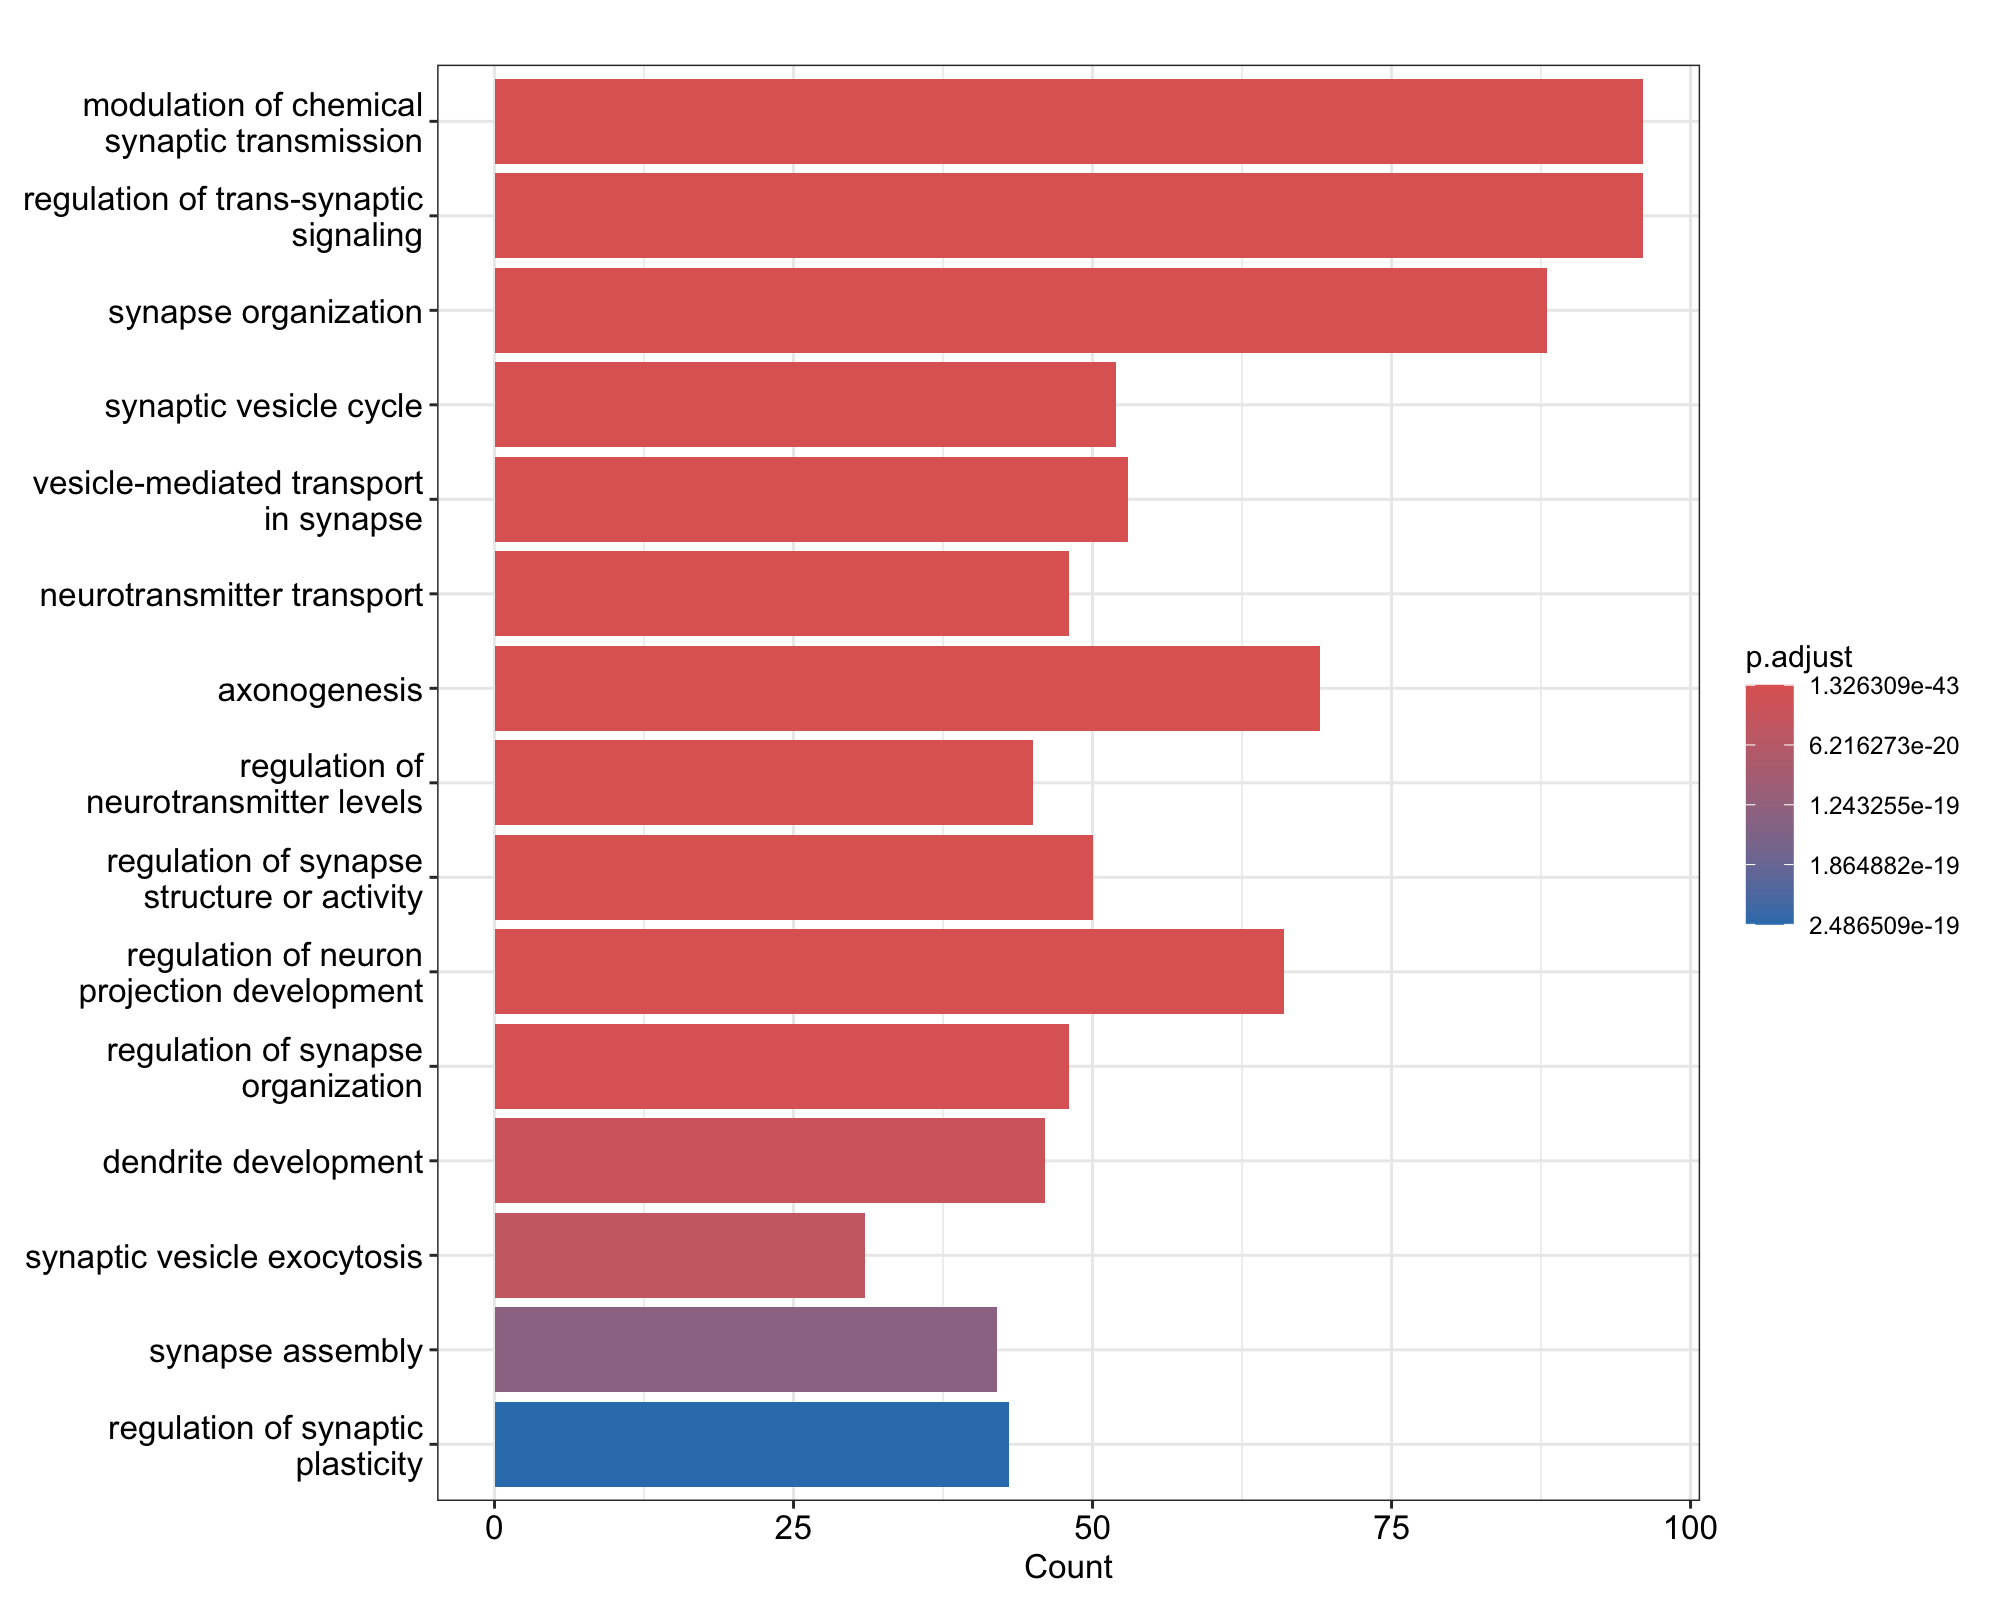

In [20]:
plot(barplot(GO_results, showCategory = 15))